### Inspect outlier detection with different metrics and especially Eq.16 for different amounts of sigma regularization, measure and plot AUROC 

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

1.15.0


In [2]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
from rnf.model import get_prior, get_posterior

In [4]:
import rnf.create_datasets as crd
import rnf.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

#### choose model by specifying the reconstruction error

In [5]:
PROJECT_PATH = "../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file = 'params_fmnist_-1_32_infoGAN_AE_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

#### set the list of minimal sigma values (at first sample from the minimal to the maximal measured sigma, then go beyond)

In [ ]:
minimums = np.arange(21)/20.*(np.sqrt(0.044)-np.sqrt(3.5e-8))+np.sqrt(3.5e-8)
minimums = np.append(minimums,max(minimums)+(np.arange(100)+1)*0.015)

### load in distribution and out of distribution data

In [6]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_set'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5

In [7]:
load_func                                         = partial(load_funcs['mnist'])
x_train_ood, y_train, x_valid_ood, y_valid, x_test_ood, y_test = load_func('mnist',flatten=False)

if np.all(x_test)==None:
    x_test_ood=x_valid_ood

x_valid_ood    = x_valid_ood/255.-0.5

In [8]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nvp')

In [9]:
def get_likelihood(decoder,sigma):
  
    def likelihood(z):
        mean = decoder({'z':z},as_dict=True)['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

In [16]:
tf.reset_default_graph()

data          = tf.placeholder(shape=params['full_size'],dtype=tf.float32)
MAP_ini       = tf.placeholder_with_default(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),shape=(params['batch_size'],params['latent_size']))
lr            = tf.placeholder_with_default(1e-4,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
sigma         = tf.placeholder_with_default(np.expand_dims(params['full_sigma'],-1),shape=[28,28,1])
sigma         = tf.cast(sigma,tf.float32)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

likelihood       = get_likelihood(decoder,sigma)
prior            = get_prior(params['latent_size'])
posterior        = get_posterior(encoder)
approx_posterior = posterior(data)

encoded         = approx_posterior.mean()

# here, the MAP lives in z-space
MAP              = tf.Variable(MAP_ini)
MAP_reset        = tf.stop_gradient(MAP.assign(MAP_ini))

#evaluate log prob of z'
MAP_prior        = nvp_funcs({'z_sample':MAP,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
#this is the Gaussian probability in u space (used to isolate log det J)
bwd_pass         = nvp_funcs({'z_sample':MAP,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']
MAP_Gauss        = prior.log_prob(bwd_pass)
# the Jacobian should be the difference
NF_Jac           = MAP_prior - MAP_Gauss

decoded          = likelihood(MAP).mean()
MAP_likelihood   = likelihood(MAP).log_prob(data)

px_tilde         = MAP_likelihood+MAP_prior

recon            = -tf.reduce_mean(tf.square(decoded-data),axis=(1,2))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#### Plot distributions of different OoD-detection metrics and measure outlier fraction at p=0.05, at measured sigma

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


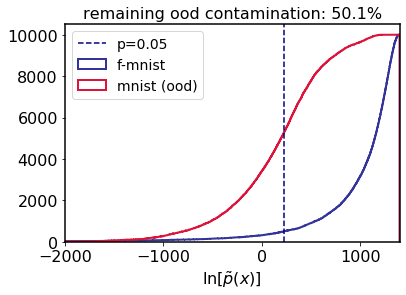

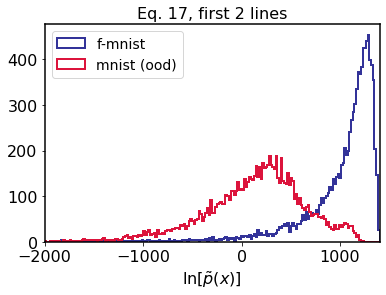

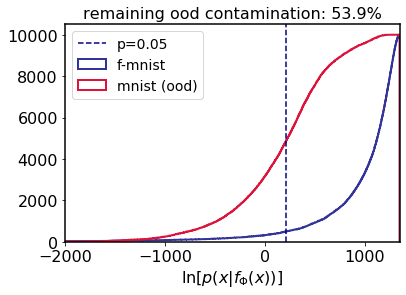

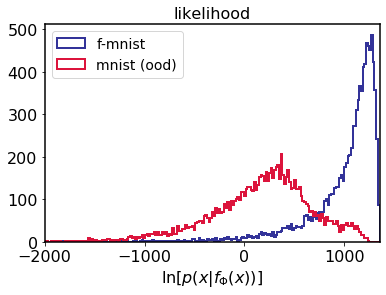

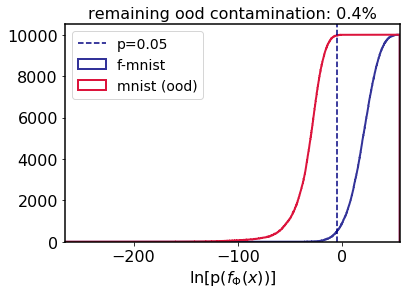

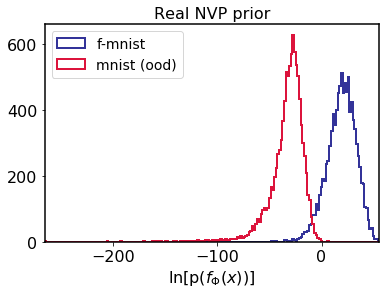

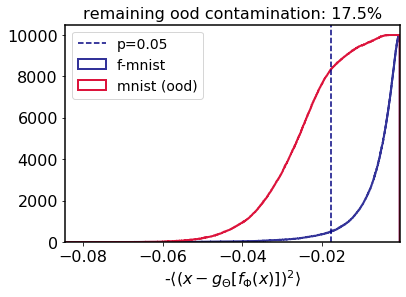

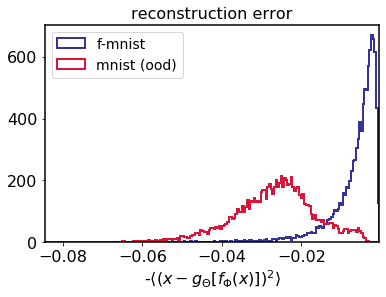

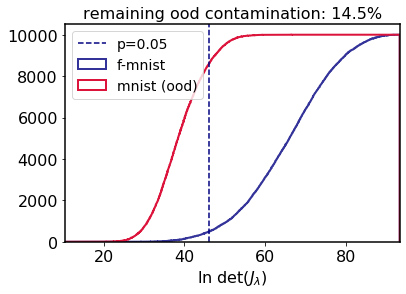

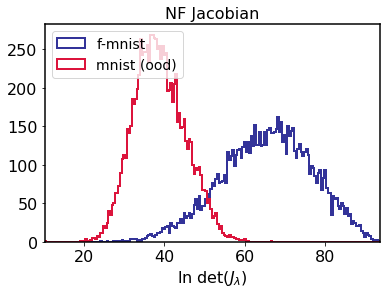

In [19]:
metrics = ['Eq. 16, first 2 lines','likelihood','Real NVP prior','reconstruction error', 'NF Jacobian']
labels  = [r'ln[$\tilde{p}(x)$]',r'ln[$p(x|f_\Phi(x))$]',r'ln[p($f_\Phi(x)$)]',r'-$\left \langle(x-g_{\Theta}[f_\Phi(x)])^2 \right\rangle$', r'ln det($J_\lambda$)']
objs    = [px_tilde,MAP_likelihood,MAP_prior,recon,NF_Jac,MAP_Gauss]

p =0.05

for jj in range(len(metrics)):
    objective=[]
    for ii in range(len(x_valid)//params['batch_size']):
        data_sample = x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]
        MAP_init = sess.run(encoded,feed_dict={data:data_sample})
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init})
        objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init})]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
    MAP_init = sess.run(encoded,feed_dict={data:data_sample})
    sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init})
    objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init})]
    objective = np.asarray(objective).flatten()[0:len(x_valid)]
    objective_ood=[]
    for ii in range(len(x_valid_ood)//params['batch_size']):
        data_sample = x_valid_ood[ii*params['batch_size']:(ii+1)*params['batch_size']]
        MAP_init = sess.run(encoded,feed_dict={data:data_sample})
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init})
        objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init})]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid_ood[(ii+1)*params['batch_size']:len(x_valid_ood)],x_valid_ood[0:params['batch_size']-delta]))
    MAP_init = sess.run(encoded,feed_dict={data:data_sample})
    sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init})
    objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init})]
    objective_ood = np.asarray(objective_ood).flatten()[0:len(x_valid)]
    
    
    low = min(min(objective_ood),min(objective))
    up  = max(max(objective_ood),max(objective))
    plt.figure()
    n,x,_=plt.hist(objective,bins=max(int((up-low)*100),10000),lw=2,cumulative=True,histtype='step',alpha=0.8,range=(low,up),label='f-mnist',color='navy')
    o,_,_=plt.hist(objective_ood,bins=max(int((up-low)*100),10000),lw=2,range=(low,up),histtype='step',cumulative=True,label='mnist (ood)',color='crimson')
    sat = np.where(n>=len(x_valid)*p)[0][0]
    plt.axvline(x[sat],ls ='--',c='navy',label='p=%.2f'%(p))
    fp =len(objective_ood)-o[sat]
    plt.title('remaining ood contamination: %.1f%%'%((fp/((1-p)*len(objective)))*100))
    plt.legend(loc='upper left',fontsize=14)
    plt.xlabel('%s'%labels[jj])
    plt.xlim(max(low,-2000),up)
    plt.show()

    plt.figure()
    low=max(low,-2000)
    plt.title('%s'%metrics[jj])
    n,x,_=plt.hist(objective,bins=200,lw=2,cumulative=False,histtype='step',alpha=0.8,range=(low,up),label='f-mnist',color='navy')
    o,_,_=plt.hist(objective_ood,bins=200,lw=2,range=(low,up),histtype='step',cumulative=False,label='mnist (ood)',color='crimson')
    plt.legend(loc='upper left',fontsize=14)
    plt.xlabel('%s'%labels[jj])
    plt.xlim(max(low,-2000),up)
    plt.show()

#### do the same thing but now loop over minimal sigmas

In [20]:
p =0.05

metrics = ['Eq. 16, first 2 lines','likelihood']
labels  = [r'ln[$\tilde{p}(x)$]',r'ln[$p(x|f_\Phi(x))$]']
objs    = [px_tilde,MAP_likelihood]

cont_fracs=[]
for minimum in minimums:
    sig = np.expand_dims(np.maximum(params['full_sigma'],minimum),-1)
    for jj in range(len(metrics)):
        objective=[]
        for ii in range(len(x_valid)//params['batch_size']):
            data_sample = x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]
            MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
            sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
            objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
        delta = len(x_valid)%params['batch_size']
        data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
        MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
        objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
        objective = np.asarray(objective).flatten()[0:len(x_valid)]

    
        objective_ood=[]
        for ii in range(len(x_valid_ood)//params['batch_size']):
            data_sample = x_valid_ood[ii*params['batch_size']:(ii+1)*params['batch_size']]
            MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
            sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
            objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
        delta = len(x_valid)%params['batch_size']
        data_sample = np.concatenate((x_valid_ood[(ii+1)*params['batch_size']:len(x_valid_ood)],x_valid_ood[0:params['batch_size']-delta]))
        MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
        sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
        objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
        objective_ood = np.asarray(objective_ood).flatten()[0:len(x_valid)]


        low = min(min(objective_ood),min(objective))
        up  = max(max(objective_ood),max(objective))
        plt.ioff()
        n,x,_=plt.hist(objective,bins=max(int((up-low)*200),10000),lw=2,cumulative=True,histtype='step',alpha=0.8,range=(low,up),label='f-mnist',color='navy')
        o,_,_=plt.hist(objective_ood,bins=max(int((up-low)*200),10000),lw=2,range=(low,up),histtype='step',cumulative=True,label='mnist (ood)',color='crimson')
        sat = np.where(n>=len(x_valid)*p)[0][0]
        fp = len(objective_ood)-o[sat]
        cont_fracs+=[(fp/((1-p)*len(objective)))*100]
        plt.close()

#### plot the outcome

In [ ]:
metrics = ['Eq. 16, first 2 lines','likelihood']
cont_fracs=np.asarray(cont_fracs).reshape((len(minimums),len(metrics)))
ind = np.where(cont_fracs[:,0]==min(cont_fracs[:,0]))
best_noise = minimums[ind[0][0]]
ind = np.where(cont_fracs[:,1]==min(cont_fracs[:,1]))
print(best_noise,minimums[-1])

best_noise_likelihood = minimums[ind[0]]
print(best_noise,best_noise_likelihood)

linestyles=['-','--',':']

plt.figure(figsize=(5.5,3))
for jj in range(len(metrics)):
    plt.semilogx(minimums,cont_fracs[:,jj],label='%s'%labels[jj], ls=linestyles[jj],lw=2)
plt.xlim(min(params['full_sigma'].flatten()),best_noise+0.3)
#plt.ylim(5,20)
plt.ylabel('contamination fraction in %')
plt.xlabel('minimum $\sigma$')
plt.legend(fontsize=14)
plt.savefig(os.path.join(params['plot_dir'],'ood_vs_regularziation_log.pdf'),bbox_inches='tight')
plt.show()


#### measure AUROC curves

In [25]:
import matplotlib

metrics = ['Eq. 16, first 2 lines','likelihood','Real NVP prior','reconstruction error']
labels  = [r'ln[$\tilde{p}(x)$]',r'ln[$p(x|f_\Phi(x))$]',r'ln[p($f_\Phi(x)$)]',r'-$\left \langle(x-g_{\Theta}[f_\Phi(x)])^2 \right\rangle$']
objs    = [px_tilde,MAP_likelihood,MAP_prior,recon]

map1 = matplotlib.cm.get_cmap('autumn')
map2 = matplotlib.cm.get_cmap('winter')

mins = [best_noise]
print(mins)


ps = np.arange(100)/100.
false_positive=[]

for nn,p in enumerate(ps):
    print(nn)
    for jj, minimum in enumerate(mins):
        sig = np.expand_dims(np.maximum(params['full_sigma'],minimum),-1)
        for jj in range(len(metrics)):
            objective=[]
            for ii in range(len(x_valid)//params['batch_size']):
                data_sample = x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]
                MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
                sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
                objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
            delta = len(x_valid)%params['batch_size']
            data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
            MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
            sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
            objective+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
            objective = np.asarray(objective).flatten()[0:len(x_valid)]


            objective_ood=[]
            for ii in range(len(x_valid_ood)//params['batch_size']):
                data_sample = x_valid_ood[ii*params['batch_size']:(ii+1)*params['batch_size']]
                MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
                sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
                objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
            delta = len(x_valid)%params['batch_size']
            data_sample = np.concatenate((x_valid_ood[(ii+1)*params['batch_size']:len(x_valid_ood)],x_valid_ood[0:params['batch_size']-delta]))
            MAP_init = sess.run(encoded,feed_dict={data:data_sample,sigma:sig})
            sess.run(MAP_reset,feed_dict={MAP_ini:MAP_init,sigma:sig})
            objective_ood+=[sess.run(objs[jj],feed_dict={data:data_sample,MAP_ini:MAP_init,sigma:sig})]
            objective_ood = np.asarray(objective_ood).flatten()[0:len(x_valid)]


            low = min(min(objective_ood),min(objective))
            up  = max(max(objective_ood),max(objective))
            plt.ioff()
            n,x,_=plt.hist(objective,bins=max(int((up-low)*200),10000),lw=2,cumulative=True,histtype='step',alpha=0.8,range=(low,up),label='f-mnist',color='navy')
            o,_,_=plt.hist(objective_ood,bins=max(int((up-low)*200),10000),lw=2,range=(low,up),histtype='step',cumulative=True,label='mnist (ood)',color='crimson')
            sat = np.where(n>=len(x_valid)*p)[0][0]
            false_positive+=[(len(objective_ood)-o[sat])/(len(objective_ood))]
            plt.close()

[1.3947617696340304]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [29]:
false_positive=np.asarray(false_positive).reshape((len(ps),len(metrics)))

#### plot AUROC curves

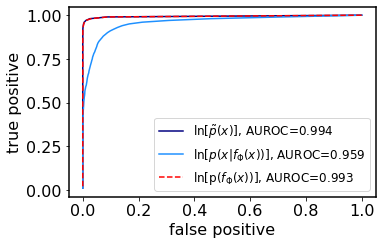

In [35]:
metrics = ['Eq. 16, first 2 lines','likelihood','Real NVP prior','reconstruction error']
labels  = [r'ln[$\tilde{p}(x)$]',r'ln[$p(x|f_\Phi(x))$]',r'ln[p($f_\Phi(x)$)]',r'-$\left \langle(x-g_{\Theta}[f_\Phi(x)])^2 \right\rangle$']
ls=['-','-','--']
colors=['navy','dodgerblue','red']
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(1,1,1)
for ii in range(len(metrics)-1):
    ax.plot(false_positive[:,ii],1-ps,label='%s, AUROC=%.3f'%(labels[ii],np.trapz(-(1-ps),false_positive[:,ii])),color=colors[ii],ls=ls[ii])
plt.legend()
# ax.plot(false_positive[:,0,0],1-ps,label='AUROC=%.3f'%(np.trapz(-(1-ps),false_positive[:,0,0])),color='k',ls=ls[0])
# handles, aurocs = ax.get_legend_handles_labels()
# first_legend = plt.legend([handles[-1]],['reconstruction error, '+aurocs[-1]])
# ax = plt.gca().add_artist(first_legend)
# plt.legend([handles[0],handles[1],handles[2]],[r'$\sigma_{min}=\sigma_{best}$, '+aurocs[0],r'$\sigma_{min}=\mathrm{min}(\hat{\sigma})$, '+aurocs[1],r'$\sigma_{min}=\mathrm{max}(\hat{\sigma})$, '%mins[2]+aurocs[2]],loc=(0.233,0.19))
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.savefig(os.path.join(params['plot_dir'],'AUROC_withbest.pdf'),bbox_inches='tight')
plt.show()

#### save results on parameter file

In [38]:
params['cont_fracs_nodens']=cont_fracs
params['true_positive']=ps
params['false_positive_nodens']=false_positive
params['minimal-sigmas']=minimums
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))